In [1]:
%run setup.ipynb

In [13]:
callset = phase2_ar1.callset_pass_biallelic
# g3R = allel.GenotypeChunkedArray(callset['3R']['calldata']['genotype'])
# g3L = allel.GenotypeChunkedArray(callset['3L']['calldata']['genotype'])
df_samples = phase2_ar1.df_samples
df_samples.reset_index(inplace=True)
populations = phase2_ar1.pop_ids
pop_labels = phase2_ar1.pop_labels
#make idx dict for subpops
idx_dic = {p : list(df_samples[df_samples.population == p].index) for p in populations}

In [3]:
region_3R_free = '3R-free', '3R', 1, 37000000
region_3L_free = '3L-free', '3L', 15000000, 41000000

In [4]:
# ac_3R = g3R.count_alleles_subpops(idx_dic)
# ac_3L = g3L.count_alleles_subpops(idx_dic)

In [5]:
def load_ac(pop_id, chrom):
    genotypes = allel.GenotypeDaskArray(callset[chrom]['calldata/genotype'])
    ac = genotypes.take(idx_dic[pop_id], axis=1).count_alleles().compute()
    return ac

In [6]:
def compute_pair_fst(pops, regions, blen=10000):
    # order is irrelevant
    pop1, pop2 = pops
    log(pop1, pop2, regions, blen)
    
    with section('load allele counts'):
        ac1 = None
        ac2 = None
        for rname, chrom, start, stop in regions:
            pos = allel.SortedIndex(callset[chrom]['variants/POS'])
            loc = pos.locate_range(start, stop)
            rac1 = load_ac(pop1, chrom)[loc]
            rac2 = load_ac(pop2, chrom)[loc]
            if ac1 is None:
                ac1 = rac1
                ac2 = rac2
            else:
                ac1 = np.vstack([ac1, rac1])
                ac2 = np.vstack([ac2, rac2])
            log(rname, ac1.shape, ac2.shape)
    
    ac1 = allel.AlleleCountsArray(ac1)
    ac2 = allel.AlleleCountsArray(ac2)
    with section('ascertain SNPs'):
        loc_asc = ac1.is_segregating() & ac2.is_segregating() & (ac1.max_allele() <= 1) & (ac2.max_allele() <= 1)
        log('ascertainment', pop1, pop2, chrom, start, stop, nnz(loc_asc))
        ac1 = ac1[loc_asc]
        ac2 = ac2[loc_asc]
        log(ac1.shape)
    
    # compute Fst
    fst, se, _, _ = allel.blockwise_hudson_fst(ac1, ac2, blen)
    
    return fst, se

In [7]:
compute_pair_fst(pops=('BFcol', 'BFgam'), regions=(region_3R_free, region_3L_free))

BFcol BFgam (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in a minute
[ascertain SNPs] begin
ascertainment BFcol BFgam 3L 15000000 41000000 2278245
(2278245, 2)
[ascertain SNPs] done in a second


(0.03246888951356084, 0.0042652011674895315)

In [8]:
def compute_pairwise_fst(regions, blen=10000):
    pairwise_fst = list()
    pairwise_fst_se = list()
    for pop1, pop2 in itertools.combinations(populations, 2):
        pops = tuple(sorted([pop1, pop2]))
        fst, se = compute_pair_fst(pops=pops, regions=regions, blen=blen)
        pairwise_fst.append(fst)
        pairwise_fst_se.append(se)
    return pairwise_fst, pairwise_fst_se

In [11]:
def tabulate_pairwise_fst(regions, blen=10000):
    fst, se = compute_pairwise_fst(regions, blen=blen)
    fstsq = scipy.spatial.distance.squareform(fst)
    sesq = scipy.spatial.distance.squareform(se)
    data = [zip(r1, r2) for r1, r2 in zip(fstsq, sesq)]
    tbl_fst = (etl
        .wrap(data)
        .pushheader(populations)
        .convertall(lambda v: '' if v == (0, 0) else '%.04f (%.04f)' % v)
        .addcolumn('population', populations, index=0)
    )
    tbl_fst.displayall(index_header=False, caption='Fst (standard error)')

In [12]:
tabulate_pairwise_fst(regions=(region_3R_free, region_3L_free))

AOcol GHcol (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin


[load allele counts] errored after 5 seconds


KeyboardInterrupt: 

In [14]:
def plot_pairwise_fst(pops, regions, mask=True, blen=10000, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))
        sns.despine(ax=ax, top=False, bottom=True, offset=0)
        
    fst, se = compute_pairwise_fst(regions, blen=blen)
    data = scipy.spatial.distance.squareform(fst).copy()
    pop_indices = [populations.index(p) for p in pops]
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    data[data < 0] = 0
    if mask:
        mask = np.zeros_like(data)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = None
    
    xtl = [pop_labels[p] for p in pops]
    ytl = list(xtl)[::-1]
#     sns.heatmap(data, ax=ax, vmin=0, cmap='Greys', 
#                 xticklabels=xtl, yticklabels=ytl, 
#                 mask=mask, cbar=False, annot=True, fmt='.3f')
    sns.heatmap(data, ax=ax, vmin=0, cmap='Greys', 
                mask=mask, cbar=False, annot=True, fmt='.3f', )
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(xtl)) + .5)
    ax.set_xticklabels(xtl, rotation=45, ha='left')
    ax.set_yticklabels(ytl, rotation=0, ha='right')
    
    ax.tick_params(length=0, pad=0)
    ax.set_xlabel('$F_{ST}$')


AOcol GHcol (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in 45 seconds
[ascertain SNPs] begin
ascertainment AOcol GHcol 3L 15000000 41000000 980434
(980434, 2)
[ascertain SNPs] done in a moment
AOcol BFcol (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in 53 seconds
[ascertain SNPs] begin
ascertainment AOcol BFcol 3L 15000000 41000000 1080998
(1080998, 2)
[ascertain SNPs] done in a moment
AOcol CIcol (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in 52 seconds
[ascertain SNPs] begin
ascertainment AOcol CIcol 3L 15000000 41000000 9

[load allele counts] done in 33 seconds
[ascertain SNPs] begin
ascertainment GHcol GNgam 3L 15000000 41000000 1574323
(1574323, 2)
[ascertain SNPs] done in a moment
GAgam GHcol (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in 46 seconds
[ascertain SNPs] begin
ascertainment GAgam GHcol 3L 15000000 41000000 1154589
(1154589, 2)
[ascertain SNPs] done in a moment
GHcol UGgam (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in 57 seconds
[ascertain SNPs] begin
ascertainment GHcol UGgam 3L 15000000 41000000 1825106
(1825106, 2)
[ascertain SNPs] done in a second
GHcol GQgam (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (85354

BFgam CIcol (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in 57 seconds
[ascertain SNPs] begin
ascertainment BFgam CIcol 3L 15000000 41000000 1944244
(1944244, 2)
[ascertain SNPs] done in a moment
CIcol GNgam (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in 39 seconds
[ascertain SNPs] begin
ascertainment CIcol GNgam 3L 15000000 41000000 1631358
(1631358, 2)
[ascertain SNPs] done in a moment
CIcol GAgam (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in 51 seconds
[ascertain SNPs] begin
ascertainment CIcol GAgam 3L 15000000 41000000

[ascertain SNPs] begin
ascertainment GAgam GW 3L 15000000 41000000 1371463
(1371463, 2)
[ascertain SNPs] done in a moment
GW UGgam (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in a minute
[ascertain SNPs] begin
ascertainment GW UGgam 3L 15000000 41000000 2418309
(2418309, 2)
[ascertain SNPs] done in a second
GQgam GW (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in 36 seconds
[ascertain SNPs] begin
ascertainment GQgam GW 3L 15000000 41000000 985291
(985291, 2)
[ascertain SNPs] done in a moment
FRgam GW (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load 

3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in 35 seconds
[ascertain SNPs] begin
ascertainment GAgam GHgam 3L 15000000 41000000 996047
(996047, 2)
[ascertain SNPs] done in a moment
GHgam UGgam (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in 45 seconds
[ascertain SNPs] begin
ascertainment GHgam UGgam 3L 15000000 41000000 1423913
(1423913, 2)
[ascertain SNPs] done in a moment
GHgam GQgam (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in 14 seconds
[ascertain SNPs] begin
ascertainment GHgam GQgam 3L 15000000 41000000 776625
(776625, 2)
[ascertain SNPs] done in a moment
FRgam GHgam (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15

(429718, 2)
[ascertain SNPs] done in a moment
GQgam KE (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in 26 seconds
[ascertain SNPs] begin
ascertainment GQgam KE 3L 15000000 41000000 374787
(374787, 2)
[ascertain SNPs] done in a second
FRgam KE (('3R-free', '3R', 1, 37000000), ('3L-free', '3L', 15000000, 41000000)) 10000
[load allele counts] begin
3R-free (8535400, 2) (8535400, 2)
3L-free (14525218, 2) (14525218, 2)
[load allele counts] done in 28 seconds
[ascertain SNPs] begin
ascertainment FRgam KE 3L 15000000 41000000 319771
(319771, 2)
[ascertain SNPs] done in a moment


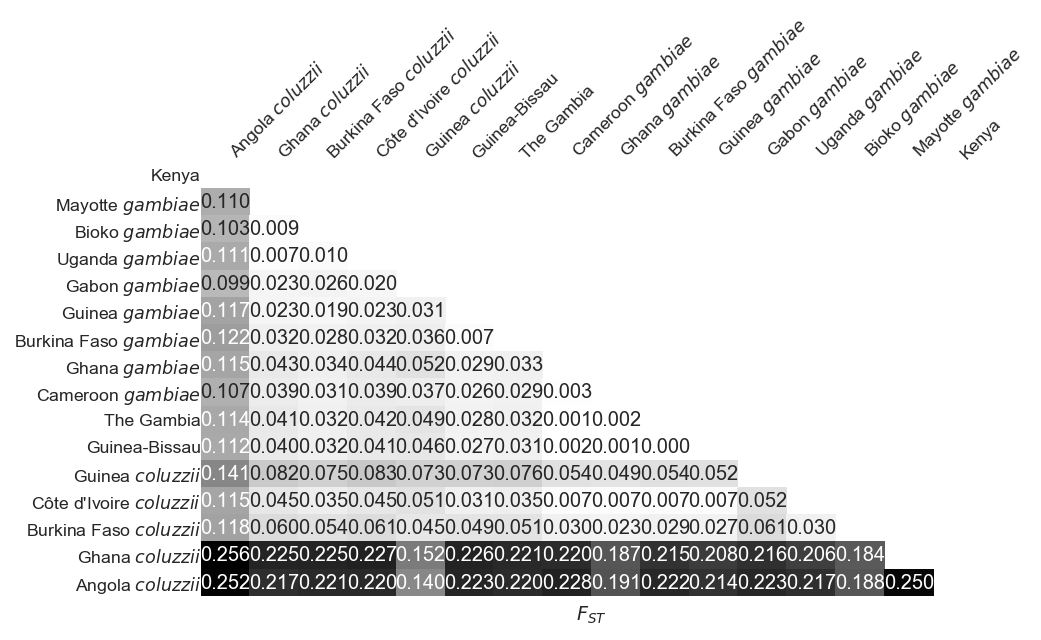

In [15]:
plot_pairwise_fst(pops=populations, regions=(region_3R_free, region_3L_free))